In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import tensorflow_hub as hub 

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


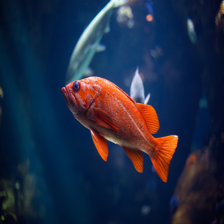

In [3]:
goldfish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
goldfish

In [4]:
goldfish = np.array(goldfish)/255.0
goldfish.shape

(224, 224, 3)

In [5]:
goldfish[np.newaxis].shape

(1, 224, 224, 3)

In [6]:
result = classifier.predict(goldfish[np.newaxis])
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1001)

In [7]:
result

array([[ 0.26351526,  2.6221786 , 10.711005  , ..., -0.10962407,
        -0.12147749, -0.52640426]], dtype=float32)

In [8]:
pred_level_index = np.argmax(result)
pred_level_index

2

In [9]:
image_labels = []
with open('ImageNetLabels.txt', 'r') as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [10]:
image_labels[2]

'goldfish'

## Now do it for flower dataset

In [11]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [12]:
data_dir

'.\\datasets\\flower_photos'

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [14]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [15]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

## Read flowers images from disk into numpy array using opencv

In [16]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [17]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [18]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [19]:
img  =  cv2.imread(str(flowers_images_dict['roses'][0]))

In [20]:
cv2.resize(img, (224,224)).shape

(224, 224, 3)

In [21]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [22]:
X = np.array(X)
y = np.array(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=0)

In [24]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [25]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

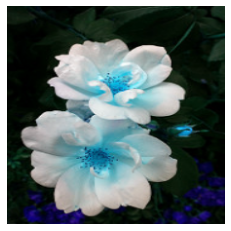

In [26]:
plt.axis('off')
plt.imshow(X[0])

In [27]:
y_pred = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
y_pred = np.argmax(y_pred, axis=1)
y_pred

1/1 [==============================] - 3s 3s/step


array([795, 880, 795], dtype=int64)

In [28]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [29]:
number_of_flowers=5
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(number_of_flowers)
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 132s 1s/step - loss: 0.8337 - acc: 0.6897
Epoch 2/5
86/86 [==============================] - 113s 1s/step - loss: 0.4248 - acc: 0.8539
Epoch 3/5
86/86 [==============================] - 115s 1s/step - loss: 0.3300 - acc: 0.8928
Epoch 4/5
45/86 [==============>...............] - ETA: 52s - loss: 0.2928 - acc: 0.9104

In [32]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 43s 1s/step - loss: 0.3837 - acc: 0.8508


[0.38372746109962463, 0.8507625460624695]